
CREDIT CARD DEFAULTS
current goals:

Feature Engineering:
1: drop ID var. DONE.
2: instead of using df, create a copy and work on the copy. DONE.
3: standardize before regression. DONE.
4: use log for any money variables. PAY DONE. BILL...
5: pay increase could be amount, not just binary.
6: calculate percentage a user pays on the bill. 7: Train with L1 regularization
8: use model.featureimportances to rank the features. DONE 9: make buckets instead of money DONE

git add file.ipynb
git commit -m 'reason for update'
git push origin master

In [101]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_validate, KFold
from sklearn.model_selection import train_test_split

cc_file = '/Users/brentmarijensen/desktop/credit_card.xls'
df = pd.read_excel(cc_file,header=1)
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [102]:
# Clean up data, as described in CreditCardEDA.  Remove invalid numbers.
clean_df = df
clean_df = clean_df.drop('ID', axis=1)

# valid EDUCATION codes are 1,2,3,4.  Change other codes to 4, meaning "others."
for i in range (len(clean_df)):
    if clean_df['EDUCATION'][i] < 1:
        clean_df['EDUCATION'][i] = 4
    elif clean_df['EDUCATION'][i] > 4:
        clean_df['EDUCATION'][i] = 4
        
# valid MARRIAGE codes are 1,2,3.  Change other codes to 3, meaning "other."
for i in range (len(clean_df)):
    if clean_df['MARRIAGE'][i] < 1:
        clean_df['MARRIAGE'][i] = 3     
        
# PAY_1 to PAY_6.  Change column name PAY_0 to PAY_1
# change negative entries to 0, indicating 0 months behind.  
# a positive integer represents the number of months behind.
clean_df=clean_df.rename(columns = {'PAY_0':'PAY_1'})
vars = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for i in range (len(clean_df)):
    for var in vars:
        if clean_df[var][i]<0:
            clean_df[var][i] = 0  
            
# Standardize the data frame, and create X for predictor variables, y for target
X = clean_df.drop('default payment next month', axis=1).values
y = clean_df['default payment next month'].values
X_scaled = scale(X)
target = 'default payment next month'

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


BASELINE SCORE:
Explore correlation with only two predictor variables: (start with 'PAY_1' and 'PAY_2' the most recent months pay history.) The obvious predictor of default is the most recent payment. If an account defaulted last month, it is more likely to default again.
This will be my baseline.
Hopefully, I can train a model to improve on it.
Note that the most important score is RECALL, because it includes false negatives (the case where I predict no default, but a default occurs.) 34% is not good. It appears that this model always predicts negative (account will NOT default.)

In [103]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

vars = ['PAY_1','PAY_2','PAY_3']

X = clean_df[vars].values
y = clean_df['default payment next month'].values
clf = LogisticRegression(random_state=22,class_weight='balanced')
clf.fit(X,y)
overall_score = cross_val_score(clf, X, y, cv=5)
scoring = ['average_precision','recall']
scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=False)

print('average cross-val score: ', overall_score.mean())
print('precision: ',scores['test_average_precision'].mean())

# Use train test split to find confusion matrix and classification report.
X = clean_df[vars].values
y = clean_df['default payment next month'].values
X_train,X_test,y_train,y_test = train_test_split(X,y)
clf = LogisticRegression(random_state=22,class_weight='balanced')
clf.fit(X_train,y_train)
pred_logreg = clf.predict(X_test)
recall_pay_only = metrics.recall_score(y_test,pred_logreg)
print('recall score: ', recall_pay_only)
confusion = metrics.confusion_matrix(y_test, pred_logreg)
print("Confusion matrix: ")
print(" TN  FP")
print(" FN  TP")
print(confusion)
print(metrics.classification_report(y_test, pred_logreg))

average cross-val score:  0.771767414199
precision:  0.468343844735
recall score:  0.525392986699
Confusion matrix: 
 TN  FP
 FN  TP
[[4975  871]
 [ 785  869]]
             precision    recall  f1-score   support

          0       0.86      0.85      0.86      5846
          1       0.50      0.53      0.51      1654

avg / total       0.78      0.78      0.78      7500



In [84]:
# Use train test split to find confusion matrix and classification report.
X = clean_df.drop('default payment next month', axis=1).values
X_scaled = scale(X)
y = clean_df['default payment next month'].values
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y)
clf = LogisticRegression(random_state=22,class_weight='balanced')
clf.fit(X_train,y_train)
pred_logreg = clf.predict(X_test)
recall_pay_only = metrics.recall_score(y_test,pred_logreg)
print('recall score: ', recall_pay_only)
confusion = metrics.confusion_matrix(y_test, pred_logreg)
print("Confusion matrix: ")
print(" TN  FP")
print(" FN  TP")
print(confusion)
print(metrics.classification_report(y_test, pred_logreg))

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


recall score:  0.585546633725
Confusion matrix: 
 TN  FP
 FN  TP
[[4961  920]
 [ 671  948]]
             precision    recall  f1-score   support

          0       0.88      0.84      0.86      5881
          1       0.51      0.59      0.54      1619

avg / total       0.80      0.79      0.79      7500



<h3> Regression </h3>

In [104]:
"""Perform Logistic regression with 10 fold cross validation. 
   Find overall score, and recall score.  Use scaled clean variables. 
   This will give us a base before feature engineering."""

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

def regress(data) :
    X = data.drop('default payment next month', axis=1).values
    X_scaled = scale(X)
    y = data['default payment next month'].values
    clf = LogisticRegression(random_state=22,class_weight='balanced')
    clf.fit(X_scaled,y)
    overall_score = cross_val_score(clf, X_scaled, y, cv=10)
    print('average cross-val score: ', overall_score.mean())
    scoring = ['average_precision','recall']
    scores = cross_validate(clf, X_scaled, y, scoring=scoring, cv=10, return_train_score=False)
    rec = scores['test_recall'].mean()
    print('recall: ', rec)
    print('precision: ',scores['test_average_precision'].mean())
    return(clf, rec)

In [105]:
x,recall_all_vars = regress(clean_df)
print('recall: ', recall_all_vars)
print('coefficients: ')
x.coef_

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


average cross-val score:  0.778637046978
recall:  0.562534981555
precision:  0.52824604243
recall:  0.562534981555
coefficients: 


array([[-0.18993393, -0.06518832, -0.04426256, -0.07530518,  0.05441789,
         0.67984805,  0.06154043,  0.12539628,  0.0806658 ,  0.08059674,
         0.10979474, -0.1265729 ,  0.12811524,  0.12417308, -0.00595097,
        -0.03914086, -0.04108786, -0.17416287, -0.16907017, -0.02826555,
        -0.03485133, -0.03144555, -0.03661152]])

In [106]:
clean_df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


'PAY_1'0.67191543, 'PAY_AMT2'-0.19955438, 'LIMIT_BAL'0.19563216, 'BILL_AMT6'-0.19415022, 'BILL_AMT1'-0.1678047, 'PAY_AMT1'0.1663637, 'BILL_AMT3'0.11607663, 'PAY_6'0.11345496, 'PAY_3'0.09891314, MARRIAGE'-0.08077255, 'SEX'-0.06069104, 'EDUCATION'-0.05517782, ' 'AGE'0.0498408, 'PAY_AMT6'-0.0492414, 'PAY_AMT4'-0.04553867, 'PAY_2'0.03600229, 'BILL_AMT5'-0.03527273, 'PAY_5'0.06667127, 'PAY_4'0.05848997, PAY_AMT5'-0.04439538, 'PAY_AMT3'-0.03135918, 'BILL_AMT6'-0.00725595, 'BILL_AMT4'-0.00563409

In [44]:
#Log Reg with unscaled data#Log Reg 
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

# Standardize the data frame, and create X for predictor variables, y for target
X = clean_df.drop('default payment next month', axis=1).values
y = clean_df['default payment next month'].values
clf = LogisticRegression(random_state=22,class_weight='balanced')
clf.fit(X,y)
overall_score = cross_val_score(clf, X, y, cv=10)
print('average cross-val score: ', overall_score.mean())
scoring = ['average_precision','recall']
scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False)
regress_recall = scores['test_recall'].mean()
print('recall: ', regress_recall)
print('precision: ',scores['test_average_precision'].mean())

average cross-val score:  0.782370491808
recall:  0.561790147013
precision:  0.520950106049


Using Log Reg on 'PAY_1', 'PAY_2', 'PAY_3', RECALL score was 0.55
Using Log Reg with all variables yields RECALL 0.64!
'PAY_1' 0.67191543 dominates, but other features have importance: 
    'LIMIT_BAL'-0.19563216, 'PAY_6'0.11345497, 'BILL_AMT1'-0.16780471, 
    'BILL_AMT2'0.16636369, 'BILL_AMT3'0.11607662, 'PAY_AMT1'-0.19415022 , 
    'PAY_AMT2'-0.19955438

In [ ]:
#GRADIENT BOOSTING CLASSIFIER (tree based classifier)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics, cross_validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

"""X = clean_df.drop('default payment next month', axis=1).values
y = clean_df['default payment next month'].values
param_grid = {'learning_rate': [0.01,0.1,1], 'n_estimators': [10,100,1000]}
clf = GradientBoostingClassifier(random_state=22)
gbc_cv = GridSearchCV(clf, param_grid, cv=5)
gbc_cv.fit(X,y)
print(gbc_cv.best_params_, gbc_cv.best_score_)"""

def gradboost (data): 
    X = data.drop('default payment next month', axis=1).values
    y = data['default payment next month'].values
    clf = GradientBoostingClassifier(random_state=22)
    clf.fit(X,y)
    scoring = ['accuracy','average_precision','recall']
    scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False)
    print('GBC mean accuracy: ', scores['test_accuracy'].mean())
    print('GBC recall: ',scores['test_recall'].mean())
    print('GBC precision: ',scores['test_average_precision'].mean()) 
    return(clf)
#importances = clf.feature_importances_
x=gradboost(clean_df)
print('')
print('feature_importances_')
x.feature_importances_


PAY_1':0.1466944, 'BILL_AMT1':0.14391388, 'BILL_AMT2':0.05944484, 'LIMIT_BAL':0.05584917, 'BILL_AMT3':0.05584334, 'PAY_AMT1'0.05522602, 'PAY_AMT2'0.04635262, 'BILL_AMT4':0.04576041, 'AGE':0.04249376, 'BILL_AMT6'0.03849269, 'PAY_2':0.03582236, 'PAY_AMT6'0.03533945, 'BILL_AMT5'0.03391295, 'PAY_AMT5'0.02994442, 'PAY_6':0.02882891, 'PAY_AMT3'0.02205736, 'EDUCATION':0.02103766, 'PAY_AMT4'0.02046777, 'PAY_3':0.01974212, 'PAY_5':0.01793303, 'MARRIAGE':0.01679349, 'PAY_4':0.01583666, 'SEX':0.01221269,

From most to least important:
'PAY_1' 0.1466944, 'BILL_AMT1' 0.14391388, 'BILL_AMT2' .05944484, 'LIMIT_BAL'0.05584917, 'BILL_AMT3'0.05584334, 'PAY_AMT1'0.05522602, 'PAY_AMT2'0.04635262, 'BILL_AMT4'0.04576041, 'AGE'0.04249376
Using GBC, no single feature dominates. PAY1 and BILLAMT1 are equal, and the next 4 features are equal to each other.

In [20]:
#GRADIENT BOOSTING CLASSIFIER (tree based classifier)#GRADIEN 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics, cross_validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

def gradboost (data): 
    X = data.drop('default payment next month', axis=1).values
    X_scaled = scale(X)
    y = data['default payment next month'].values
    clf = GradientBoostingClassifier(random_state=22)
    clf.fit(X,y)
    scoring = ['accuracy','average_precision','recall']
    scores = cross_validate(clf, X_scaled, y, scoring=scoring, cv=10, return_train_score=False)
    print('GBC mean accuracy: ', scores['test_accuracy'].mean())
    print('GBC recall: ',scores['test_recall'].mean())
    print('GBC precision: ',scores['test_average_precision'].mean()) 
    return(clf)

In [22]:
gbc= gradboost(clean_df)
print(gbc_cv.best_params_best_par , gbc_cv.best_score_)

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


GBC mean accuracy:  0.820902850697
GBC recall:  0.366340702175
GBC precision:  0.559594330195


NameError: name 'gbc_cv' is not defined


***EDUCATION and MARRIAGE***

run AGE before EDU and MARR (i don't know why, but other way causes error.)

In [108]:
#create new boolean categories to separate out education (1-4) and marriage (1-3)#create  
#drop one of each, because redundant info
mar = pd.get_dummies(clean_df['MARRIAGE'],prefix='mar') #create marriage binaries
mar = mar.drop('mar_3', axis=1) #drop one binary (all info contained in the remainder)
clean_df = clean_df.drop('MARRIAGE',axis=1) #drop old marriage variable
clean_df = clean_df.join(mar) #attach binaries to the dataframe

edu = pd.get_dummies(clean_df['EDUCATION'],prefix='edu') #create education binaries
edu = edu.drop('edu_4', axis=1)
clean_df = clean_df.drop('EDUCATION',axis=1) #drop old education variable
clean_df = clean_df.join(edu) #attach binaries to the  dataframe

In [146]:
print(clean_df['mar_1'].sum())
print(clean_df['mar_2'].sum())

13659
15964


***AGE***

In [107]:
#AGE -> combine AGE into bins, boolean labels for age groups
clean_df['AgeBin1']=0
clean_df['AgeBin2']=0
clean_df['AgeBin3']=0
clean_df['AgeBin4']=0
clean_df['AgeBin5']=0
for i in range(len(clean_df)):
    if (clean_df['AGE'][i] < 30):
        clean_df['AgeBin1'][i] += 1
    elif (clean_df['AGE'][i] < 40):
        clean_df['AgeBin2'][i] += 1
    elif (clean_df['AGE'][i] < 50):
        clean_df['AgeBin3'][i] += 1
    elif (clean_df['AGE'][i] < 60):
        clean_df['AgeBin4'][i] += 1
        
clean_df = clean_df.drop('AGE', axis=1)
print(clean_df['AgeBin1'].sum())        
print(clean_df['AgeBin2'].sum()) 
print(clean_df['AgeBin3'].sum()) 
print(clean_df['AgeBin4'].sum()) 
print(clean_df['AgeBin5'].sum())

9618
11238
6464
2341
0


*** BILL_AMT 1-6 ***
* Compare current bill to previous, to see if it has increased *


In [109]:
# ONE MONTH BILL COMPARE.  measure if the bill amount increased 
# True if AMT1(Sep) is more than the previous month.
clean_df['BILL_UP'] = ( (clean_df['BILL_AMT1']>clean_df['BILL_AMT2']) ) 
print(clean_df['BILL_UP'].value_counts())

False    16850
True     13150
Name: BILL_UP, dtype: int64


In [ ]:
# TWO MONTH BILL COMPARE.  measure if the bill amount increased # TWO MO 
# True if AMT1(Sep) is more than any of the previous 2 months.
clean_df['BILL_UP'] = ( (clean_df['BILL_AMT1']> clean_df['BILL_AMT2']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT3'])  ) 
print(clean_df['BILL_UP'].value_counts())

In [ ]:
# THREE MONTH BILL COMPARE.  measure if the bill amount increased # THREE  
# True if AMT1(Sep) is more than any of the previous 3 months.
clean_df['BILL_UP'] = ( (clean_df['BILL_AMT1']> clean_df['BILL_AMT2']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT3']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT4']) ) 
print(clean_df['BILL_UP'].value_counts())

In [ ]:
# FOUR MONTH BILL COMPARE.  Measure if the bill amount increased 
# True if AMT1(Sep) is more than any of the previous 4 months.
clean_df['BILL_UP'] = ( (clean_df['BILL_AMT1']> clean_df['BILL_AMT2']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT3']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT4']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT5']) ) 
print(clean_df['BILL_UP'].value_counts())

In [110]:
# FIVE MONTH increase.  Measure if the bill amount increased # FIVE M 
# True if AMT1(Sep) is more than any of the previous 5 months.
clean_df['BILL_UP_ALL_MONTHS'] = ( (clean_df['BILL_AMT1']> clean_df['BILL_AMT2']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT3']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT4']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT5']) | 
                        (clean_df['BILL_AMT1']> clean_df['BILL_AMT6']) ) 
print(clean_df['BILL_UP'].value_counts())

False    16850
True     13150
Name: BILL_UP, dtype: int64


***PAY 1-6***  
**compare current payment to previous payments, to see if it has increased**

In [111]:
# ONE MONTH PAY COMPARE.  measure if the pay amount increased 
# True if AMT1(Sep) is more than the previous month.
clean_df['PAY_UP'] = ( (clean_df['PAY_1']>clean_df['PAY_2']) ) 
print(clean_df['PAY_UP'].value_counts())

False    26779
True      3221
Name: PAY_UP, dtype: int64


In [ ]:
# TWO MONTH PAY COMPARE.  measure if the payment amount increased # TWO MO 
# True if AMT1(Sep) is more than any of the previous 2 months.
clean_df['PAY_UP'] = ( (clean_df['PAY_1']>clean_df['PAY_2']) | 
                      (clean_df['PAY_1']>clean_df['PAY_3']) ) 
print(clean_df['PAY_UP'].value_counts())

In [ ]:
# THREE MONTH PAY COMPARE.  measure if the payment amount increased 
# True if AMT1(Sep) is more than any of the previous 3 months.
clean_df['PAY_UP'] = ( (clean_df['PAY_1']>clean_df['PAY_2']) | 
                      (clean_df['PAY_1']>clean_df['PAY_3']) | 
                      (clean_df['PAY_1']>clean_df['PAY_4']) ) 
print(clean_df['PAY_UP'].value_counts())

In [ ]:
# FOUR MONTH PAY COMPARE.  Measure if the payment amount increased 
# True if AMT1(Sep) is more than any of the previous 4 months.
clean_df['PAY_UP'] = ( (clean_df['PAY_1']>clean_df['PAY_2']) | 
                      (clean_df['PAY_1']>clean_df['PAY_3']) | 
                      (clean_df['PAY_1']>clean_df['PAY_4']) | 
                      (clean_df['PAY_1']>clean_df['PAY_5']) ) 
print(clean_df['PAY_UP'].value_counts())

In [112]:
# FIVE MONTH PAY COMPARE.  Measure if the payment amount increased 
# True if AMT1(Sep) is more than any of the previous 5 months.
clean_df['PAY_UP_ALL_MONTHS'] = ( (clean_df['PAY_1']>clean_df['PAY_2']) | 
                      (clean_df['PAY_1']>clean_df['PAY_3']) | 
                      (clean_df['PAY_1']>clean_df['PAY_4']) | 
                      (clean_df['PAY_1']>clean_df['PAY_5']) | 
                      (clean_df['PAY_1']>clean_df['PAY_6']) ) 
print(clean_df['PAY_UP'].value_counts())

False    26779
True      3221
Name: PAY_UP, dtype: int64


<h4> PAY AMOUNT LOG SCALE </H4>

In [113]:
# PAY amounts change scale to log
from math import log
for i in range(6):
    i+=1
    clean_df['PAY_AMT_LOG'+str(i)] = clean_df['PAY_AMT'+str(i)].apply(lambda x: log(x+1))
    clean_df = clean_df.drop('PAY_AMT'+str(i), axis=1)

<h4> BILL AMOUNT LOG SCALE </H4>

In [114]:
# BILL amounts change scale to log# BILL a 
from math import log

for i in range(6):
    i+=1
    clean_df['BILL_AMT_LOG'+str(i)] =clean_df['BILL_AMT'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)

Create new variable, OWED1-6, indicating amount owed. BILL_AMT1-6 - PAY_AMT1-6 Then remove bill amt.

In [115]:
clean_df['OWED_1'] = clean_df['BILL_AMT1'] - clean_df['PAY_1']
clean_df['OWED_2'] = clean_df['BILL_AMT2'] - clean_df['PAY_2']
clean_df['OWED_3'] = clean_df['BILL_AMT3'] - clean_df['PAY_3']
clean_df['OWED_4'] = clean_df['BILL_AMT4'] - clean_df['PAY_4']
clean_df['OWED_5'] = clean_df['BILL_AMT5'] - clean_df['PAY_5']
clean_df['OWED_6'] = clean_df['BILL_AMT6'] - clean_df['PAY_6']

In [116]:
model, recall_engineered =regress(clean_df)
print('coefficients: ')
print(model.coef_)

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


average cross-val score:  0.763505256797
recall:  0.599609069763
precision:  0.532807881312
coefficients: 
[[-0.2406515  -0.06590725  0.75085162 -0.02482301  0.08895082  0.02241849
   0.071694    0.10603418  0.06407783  0.02740776 -0.00831764  0.00572793
   0.01244345 -0.025895   -0.10535128 -0.11643086 -0.06371679 -0.044059    0.
   0.04646771 -0.03817659  0.48818054  0.52325001  0.37276153 -0.08825033
  -0.07087758 -0.11503368 -0.00935775 -0.1837679  -0.09454923 -0.15277108
  -0.08298895 -0.04498197 -0.04030534 -0.02276663  0.01196248  0.06624761
   0.07894841 -0.05782749  0.0355093   0.06407008  0.02740804 -0.00831865
   0.00572766  0.01244261 -0.02589628]]


In [117]:
clean_df.columns

Index(['LIMIT_BAL', 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'default payment next month', 'AgeBin1',
       'AgeBin2', 'AgeBin3', 'AgeBin4', 'AgeBin5', 'mar_1', 'mar_2', 'edu_1',
       'edu_2', 'edu_3', 'BILL_UP', 'BILL_UP_ALL_MONTHS', 'PAY_UP',
       'PAY_UP_ALL_MONTHS', 'PAY_AMT_LOG1', 'PAY_AMT_LOG2', 'PAY_AMT_LOG3',
       'PAY_AMT_LOG4', 'PAY_AMT_LOG5', 'PAY_AMT_LOG6', 'BILL_AMT_LOG1',
       'BILL_AMT_LOG2', 'BILL_AMT_LOG3', 'BILL_AMT_LOG4', 'BILL_AMT_LOG5',
       'BILL_AMT_LOG6', 'OWED_1', 'OWED_2', 'OWED_3', 'OWED_4', 'OWED_5',
       'OWED_6'],
      dtype='object')

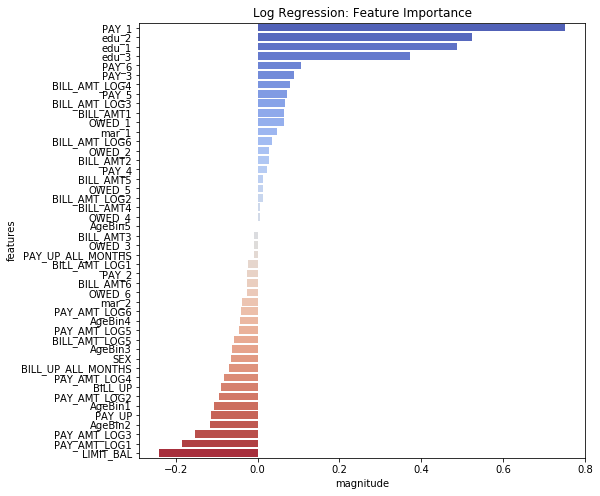

In [151]:
#show feature importance coefficients, in order of magnitude of importance.
import seaborn as sns
importance = pd.DataFrame()
importances = model.coef_[0][:]  #change coefficients dataframe into a series
labels = clean_df.drop('default payment next month', axis=1).columns.values
importance['magnitude'] = importances
importance['features'] = labels
importance = importance.sort_values(by='magnitude', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
sns.barplot(x='magnitude', y='features', data=importance.iloc[0:46,:], ax=ax, palette="coolwarm")
plt.title("Log Regression: Feature Importance")
plt.show()